# Setup

In [1]:
!pip install ruptures loadmydata
!pip install loadmydata
!pip install pygsp
!pip install geopandas
!pip install contextily

     |████████████████████████████████| 991 kB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 271 kB 15.4 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
  Created wheel for loadmydata: filename=loadmydata-0.0.9-py3-none-any.whl size=17913 sha256=a67b322481bf6d491b9a3f0677f290d211bb7e6b4bff50b4abcfc7d667011712
  Stored in directory: /root/.cache/pip/wheels/58/4c/21/8b85f542be6892eae1347f269901606ba1a101a202d8fb1e10
Successfully built loadmydata
     |████████████████████████████████| 1.8 MB 4.4 MB/s 
     |████████████████████████████████| 1.0 MB 4.2 MB/s 
     |████████████████████████████████| 6.3 MB 43.8 MB/s 
     |████████████████████████████████| 16.7 MB 438 kB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


**Imports**

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from math import *
import pandas as pd
from ruptures.metrics import hamming
from ruptures.metrics import hamming
from scipy import stats
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from pygsp import graphs
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from matplotlib.dates import DateFormatter
import geopandas
import contextily as cx
from tqdm import tqdm

**Utility functions**

In [4]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

def predict_piecewise(signal, bkps):
    signal_proj = np.zeros(signal.shape)
    for i in range(signal.shape[1]):
        for j in range(len(bkps)-1) :
            signal_proj[bkps[j]:bkps[j+1],i] = np.mean(signal[bkps[j]:bkps[j+1],i])
    return signal_proj

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

# Question 2

In [5]:
# generate signal
n_samples = [100, 200, 500, 1000]
n_bkps = [2, 4, 6, 8, 10]
n_dims = 2
sigma_noise = [1, 2, 5, 7]

signal_with_noise_list = []
true_signal_list = []
indexes = []
bkps_list = []

for sample in n_samples :
  for bkp in n_bkps :
    for sigma in sigma_noise :

      signal, bkps = rpt.pw_constant(
          n_samples=sample, n_features=n_dims, n_bkps=bkp, noise_std=0
      )
      signal_with_noise = signal + np.random.normal(
          scale=sigma, size=signal.shape
      )
      
      bkps_list.append(bkps) 
      signal_with_noise_list.append(signal_with_noise)
      true_signal_list.append(signal)
      indexes.append([sample,bkp,sigma])


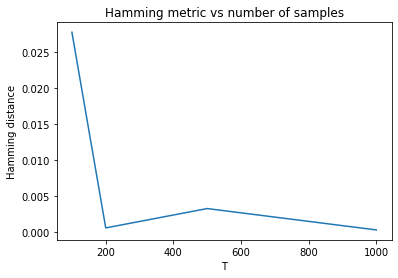

In [8]:
# to detect mean shift, use the faster dynamic programming algorithm in rpt.KernelCPD(kernel="linear")

# for a fixed sigma :
SIGMA = 2

hamming_average_list = []

for sample in n_samples :

    hamming_bkp_list = []

    for bkp in n_bkps :

        # retrieve index of the three values
        idx = indexes.index([sample,bkp,SIGMA])

        signal_with_noise = signal_with_noise_list[idx]

        true_bkps=bkps_list[idx]

        var_empirique = np.var(signal_with_noise[:len(signal_with_noise//10)])

        algo = rpt.KernelCPD(kernel="linear").fit(signal_with_noise)
        predicted_bkps = algo.predict(n_bkps = bkp, pen=var_empirique*2*n_dims)  # the penality already takes into account tau/T in the source code
        dist = hamming(true_bkps,predicted_bkps)

        hamming_bkp_list.append(dist)

    hamming_average_list.append(np.mean(hamming_bkp_list))

plt.title('Hamming metric vs number of samples')
plt.xlabel('T')
plt.ylabel('Hamming distance')
plt.plot(n_samples, hamming_average_list)

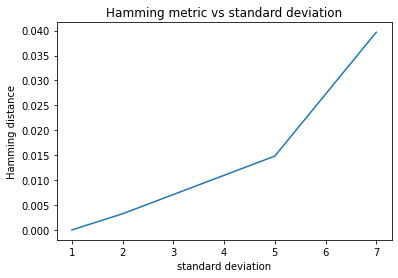

In [9]:
T = 500

hamming_average_list_sigma = []

for sigma in sigma_noise :
    hamming_bkp_list = []
    for bkp in n_bkps :
        idx = indexes.index([T,bkp,sigma])
        signal_with_noise = signal_with_noise_list[idx]
        true_bkps=bkps_list[idx]

        var_empirique = np.var(signal_with_noise[:len(signal_with_noise//10)])

        algo = rpt.KernelCPD(kernel="linear").fit(signal_with_noise)
        predicted_bkps = algo.predict(n_bkps = bkp, pen=var_empirique*2*n_dims) 
        dist = hamming(true_bkps,predicted_bkps)

        hamming_bkp_list.append(dist)

    hamming_average_list_sigma.append(np.mean(hamming_bkp_list))

plt.title('Hamming metric vs standard deviation')
plt.xlabel('standard deviation')
plt.ylabel('Hamming distance')
plt.plot(sigma_noise, hamming_average_list_sigma)

# Question 3

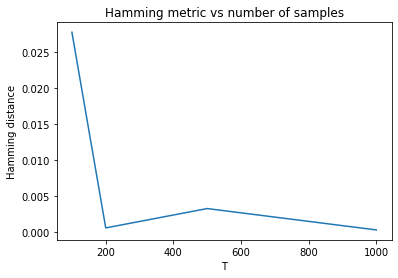

In [10]:
# to detect mean shift, use the faster dynamic programming algorithm in rpt.KernelCPD(kernel="linear")

# for a fixed sigma :
SIGMA = 2

hamming_average_list_slope = []

for sample in n_samples :
    hamming_bkp_list = []
    x = range(15, int(0.4 * sample))
    for bkp in n_bkps :

        idx = indexes.index([sample,bkp,SIGMA])
        signal_with_noise = signal_with_noise_list[idx]
        algo = rpt.KernelCPD(kernel="linear").fit(signal_with_noise)
        true_bkps=bkps_list[idx]
        true_signal = true_signal_list[idx]

        tau_list = []
        for k in x :
            signal_pred = predict_piecewise(signal_with_noise,algo.predict(n_bkps = k))
            
            tau_list.append(np.linalg.norm(signal_pred-true_signal))

        slope = stats.linregress(x,tau_list)[0]
        
        pen_slope = -n_dims*slope*sample # because of the way algo.predict is coded we don't put the tau/T in the formula

        predicted_bkps = algo.predict(n_bkps = bkp, pen=pen_slope)  # minimizes the linearly penalized sum of costs (with beta=10)
        dist = hamming(true_bkps,predicted_bkps)

        hamming_bkp_list.append(dist)

    hamming_average_list_slope.append(np.mean(hamming_bkp_list))
plt.title('Hamming metric vs number of samples')
plt.xlabel('T')
plt.ylabel('Hamming distance')
plt.plot(n_samples, hamming_average_list_slope)

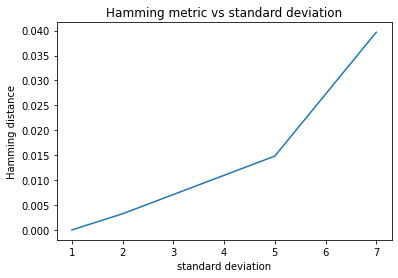

In [11]:
T = 500

hamming_average_list_slope = []

for sigma in sigma_noise :
    hamming_bkp_list = []
    x = range(15, int(0.4 * T))

    for bkp in n_bkps :

        idx = indexes.index([T,bkp,sigma])
        signal_with_noise = signal_with_noise_list[idx]
        algo = rpt.KernelCPD(kernel="linear").fit(signal_with_noise)
        true_bkps=bkps_list[idx]
        true_signal = true_signal_list[idx]

        tau_list = []
        for k in x :

            signal_pred = predict_piecewise(signal_with_noise,algo.predict(n_bkps = k))
            tau_list.append(np.linalg.norm(signal_pred-true_signal))

        slope = stats.linregress(x,tau_list)[0]
        
        pen_slope = -n_dims*slope*T

        predicted_bkps = algo.predict(n_bkps = bkp, pen=pen_slope)  # minimizes the linearly penalized sum of costs (with beta=10)
        dist = hamming(true_bkps,predicted_bkps)

        hamming_bkp_list.append(dist)

    hamming_average_list_slope.append(np.mean(hamming_bkp_list))
plt.title('Hamming metric vs standard deviation')
plt.xlabel('standard deviation')
plt.ylabel('Hamming distance')
plt.plot(sigma_noise, hamming_average_list_slope)

# Question 4

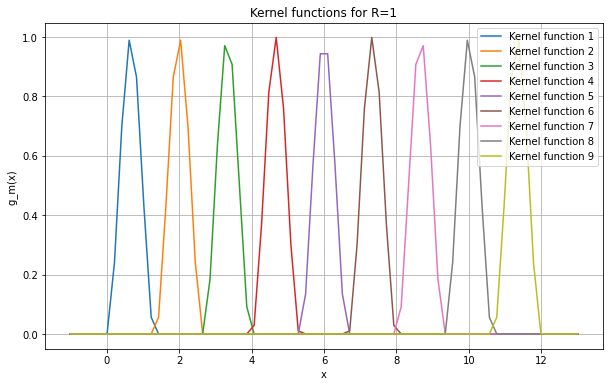

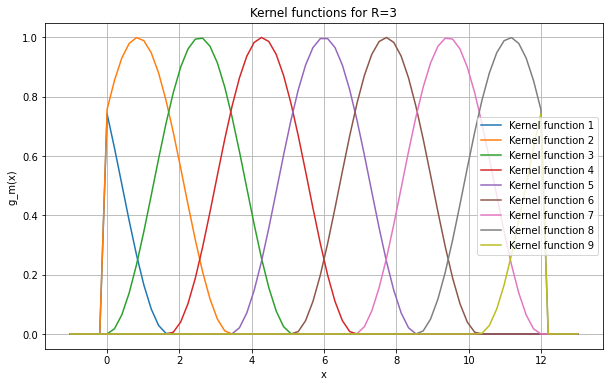

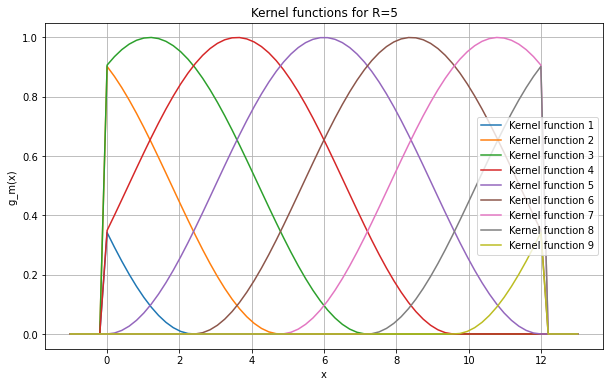

In [12]:
M=9
lambda_n = 12

def g_U(lambd, lambda_n, R, a):

    if (lambd > -R*a) and (lambd < 0) : 
        return 0.5*(1+cos(2*pi*(lambd/(a*R) +0.5)))
    else : 
      return 0

def g(m,lambd, lambda_n, R, a):
    if (lambd > 0)  and (lambd < lambda_n) :
        return g_U(lambd-a*m, lambda_n, R, a)
    else :
        return 0


def g_vect(x,m,lambda_n, R, a):
    return [g(m,i,lambda_n, R, a) for i in x]


def plot_kernel_functions(R):
    x = np.linspace(-1,lambda_n +1,70)
    a = lambda_n /(M+1-R)
    fig, ax = plt.subplots(figsize=(10,6))
    for m in range(1,M+1):
        y = g_vect(x,m, lambda_n, R, a)
        ax.plot(x, y,label='Kernel function '+str(m))
        ax.set(xlabel='x', ylabel='g_m(x) ')
    ax.grid()
    ax.legend()
    ax.set_title('Kernel functions for R='+str(R))
    plt.show()


plot_kernel_functions(1)       
plot_kernel_functions(3)
plot_kernel_functions(5)


    

# Question 5

In [13]:
data_df, stations_df, description = load_molene_meteo_dataset()

100%|██████████| 1.14M/1.14M [00:16<00:00, 69.2kiB/s]
100%|██████████| 5.06k/5.06k [00:00<00:00, 1.52MiB/s]


In [14]:
data_df["temp"] = data_df.t - 273.15

temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)



temperature_df = temperature_df.dropna(axis=1)

temperature_df.head()



station_name,AURAY,BELLE ILE-LE TALUT,BIGNAN,DINARD,GUERANDE,GUISCRIFF SA,ILE DE GROIX,ILE-DE-BREHAT,KERPERT,LORIENT-LANN BIHOUE,...,SAINT-CAST-LE-G,SAINT-JOACHIM_SAE,SARZEAU SA,SIBIRIL S A,SPEZET,ST BRIEUC,ST-SEGAL S A,THEIX,TREGUNC,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,10.3,11.3,7.1,6.8,10.4,8.3,9.0,7.0,5.9,9.0,...,6.1,9.3,9.8,7.4,8.3,7.5,9.0,9.3,10.8,9.7
2014-01-01 01:00:00,10.4,10.3,7.6,6.5,10.6,7.8,10.0,7.0,5.9,10.0,...,6.3,9.3,9.9,8.2,8.6,7.0,9.5,9.1,10.9,9.9
2014-01-01 02:00:00,10.0,11.2,7.7,6.5,10.2,8.4,9.5,7.8,6.4,8.9,...,6.4,9.5,9.2,8.5,8.6,7.5,9.4,9.4,10.6,9.6
2014-01-01 03:00:00,10.4,11.4,7.9,7.1,10.6,8.4,10.4,8.3,6.7,10.1,...,7.0,9.0,10.1,8.5,8.9,7.2,9.9,8.9,10.8,9.8
2014-01-01 04:00:00,10.8,11.4,8.8,7.6,10.6,8.9,10.8,8.9,6.9,10.4,...,7.7,9.9,10.5,9.1,9.4,7.6,10.0,9.6,11.0,10.2


In [15]:
stations_df=stations_df[stations_df.Nom.isin(temperature_df.columns.unique())]
stations_df.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131
5,22168001,PLOUMANAC'H,48.825833,-3.473167,173516,2441036,55


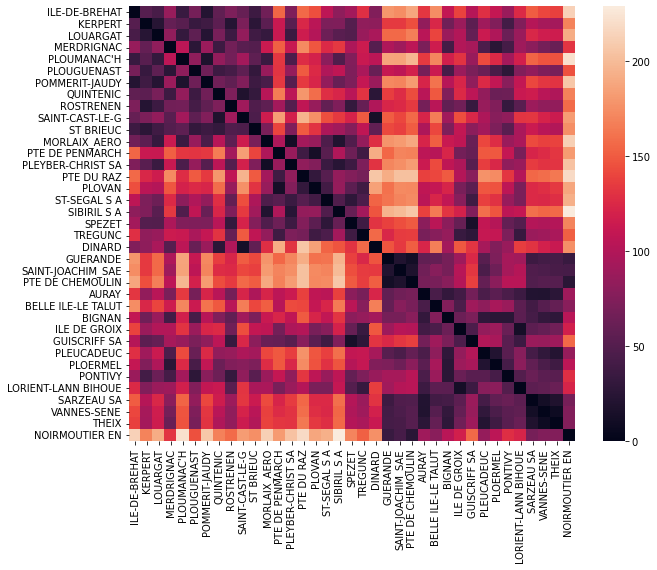

In [16]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

fig, ax = fig_ax((10, 8))
_ = sns.heatmap(
    dist_mat_square,
    xticklabels=stations_df.Nom,
    yticklabels=stations_df.Nom,
    ax=ax,
)

In [17]:
sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = 0.83
adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
print(
    f"The graph is {'not ' if not G_gaussian.is_connected(recompute=True) else ''}connected, with {G_gaussian.N} nodes, {G_gaussian.Ne} edges"
)

The graph is connected, with 37 nodes, 75 edges


In [18]:
print(np.mean(G_gaussian.d))
print(G_gaussian.is_connected())

4.054054054054054
True


In [19]:
signals = temperature_df.to_numpy()
laplacian_matrix = G_gaussian.L.todense()

smoothness_arr = np.array(
    [float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals]
)

smoothness_df = pd.Series(
    data=smoothness_arr, index=temperature_df.index
)

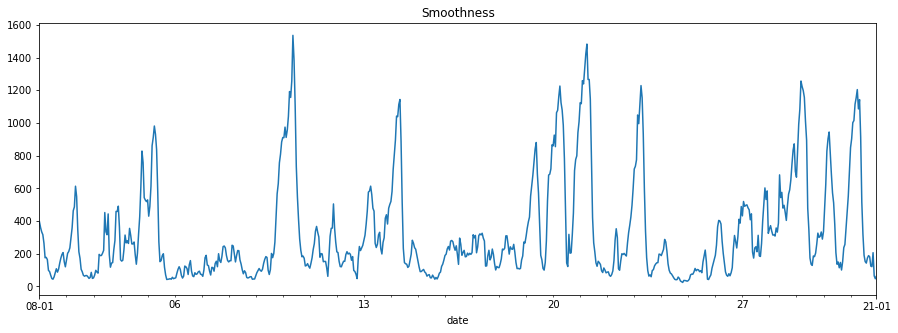

In [20]:
fig, ax = fig_ax()
smoothness_df.plot(ax=ax)
myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")

# Smoothest signal

In [21]:
CRS = "EPSG:4326"
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

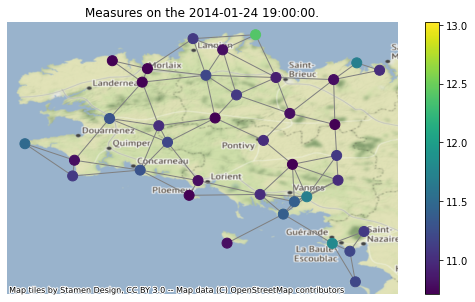

In [22]:
argmin_index = smoothness_df.argmin()
signal_smooth = temperature_df.iloc[argmin_index].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal_smooth, ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df.index[argmin_index]}."
)

# Least smooth signal

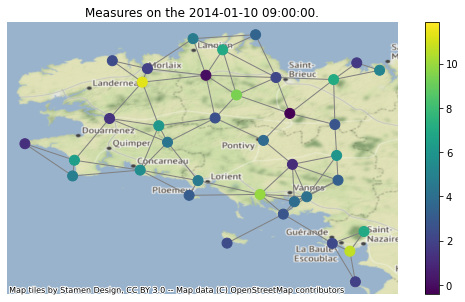

In [23]:
argmax_index = smoothness_df.argmax()
signal_unsmooth = temperature_df.iloc[argmax_index].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal_unsmooth, ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df.index[argmax_index]}."
)

# Question 6

In [36]:

M=9
R=3
lambda_n = G_gaussian.e[-1]
a = lambda_n /(M+1-R)
def W(signal,m,node):
    fourier_f = np.transpose(G_gaussian.U)@signal
    g_hat = g_vect(G_gaussian.e,m,lambda_n,R,a)
    u_node = G_gaussian.U[node]

    GFT = fourier_f*g_hat*u_node
    
    return np.sum(GFT)

def get_frequency(signal,node):
    return [1,2,3][np.argmax([np.abs(W(signal,1,node))**2+np.abs(W(signal,2,node))**2+np.abs(W(signal,3,node))**2,
                              np.abs(W(signal,4,node))**2+np.abs(W(signal,5,node))**2+np.abs(W(signal,6,node))**2,
                              np.abs(W(signal,7,node))**2+np.abs(W(signal,8,node))**2+np.abs(W(signal,9,node))**2])]


def plot_frequency(signal,idx):
    colormap = np.zeros(len(signal))
    for node in range(len(signal)): 
        colormap[node] = get_frequency(signal,node)
    ax = stations_gdf.geometry.plot(figsize=(10, 5))
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    G_gaussian.set_coordinates(stations_np)
    G_gaussian.plot_signal(colormap, ax=ax)
    _ = ax.set_title(
        f"Measures on the {temperature_df.index[idx]}."
    )



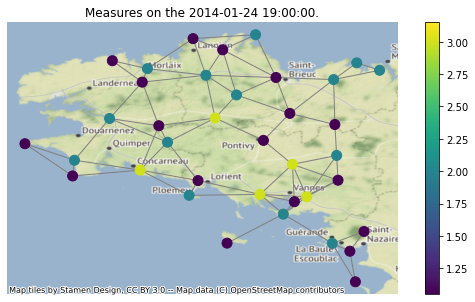

In [37]:
plot_frequency(signal_smooth,argmin_index)

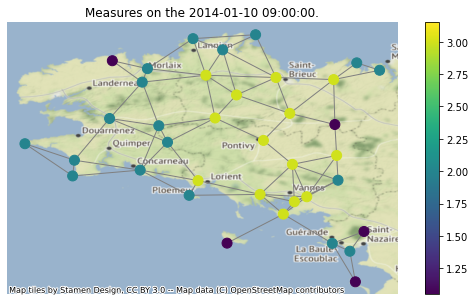

In [38]:
plot_frequency(signal_unsmooth,argmax_index)

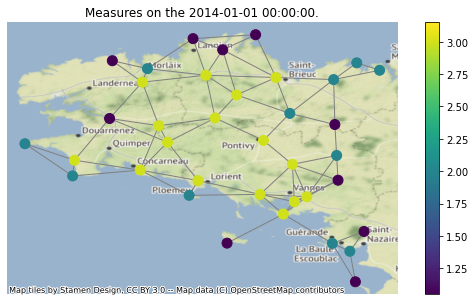

In [39]:
plot_frequency(temperature_df.iloc[0],0)

# Question 7

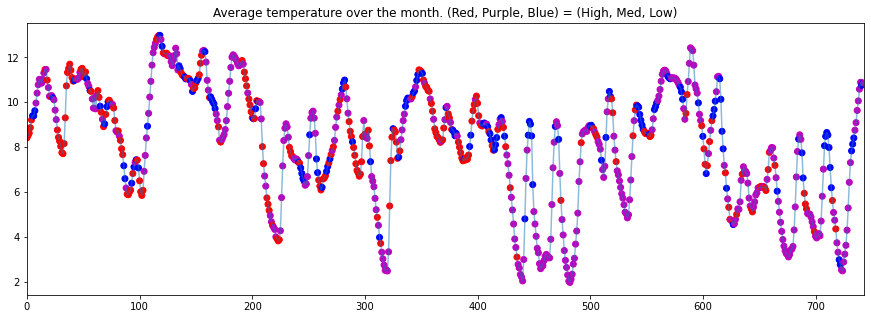

In [35]:
y = np.zeros(len(temperature_df))
majority_class = []
for i in range(len(temperature_df)):
    signal = temperature_df.iloc[i].to_numpy()
    colormap=np.zeros(len(signal))
    for node in range(len(signal)): 
        colormap[node] = get_frequency(signal,node)
    majority_class.append(np.argmax([np.sum(colormap==1),np.sum(colormap==2),np.sum(colormap==3)]).astype(int))    
    y[i]=np.mean(signal)

x = np.arange(len(temperature_df))


colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, majority_class)
fig, ax = fig_ax()
ax.set_title('Average temperature over the month. (Red, Purple, Blue) = (High, Med, Low)')
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)

# do not forget to explain the colours in the reportc

# Question 8

In [72]:
from scipy import sparse
laplacian_temp = np.zeros((len(temperature_df),len(temperature_df)))
i,j = np.indices(laplacian_temp.shape)


laplacian_temp[i==j] = 2
laplacian_temp[i==j-1] = -1
laplacian_temp[i==j+1] = -1



Id_temp = 0
Id_spat = 0




In [73]:
eigenvalues_temp, eigenvectors_temp = np.linalg.eig(laplacian_temp)
idx = eigenvalues_temp.argsort()   
eigenvalues_temp = eigenvalues_temp[idx]
eigenvectors_temp = eigenvectors_temp[:,idx]


In [74]:
eigenvalues_spat, eigenvectors_spat = np.linalg.eig(laplacian_matrix)
idx = eigenvalues_spat.argsort()   
eigenvalues_spat = eigenvalues_spat[idx]
eigenvectors_spat = eigenvectors_spat[:,idx]


In [75]:
eigenvalues_spatiotemp = []
eigenvectors_spatiotemp = []
fourier_transform = []
g_list = []
W_list= np.zeros(G_gaussian.N*len(temperature_df))

In [76]:
M=9
R=3
lambda_n = eigenvalues_spat[-1]+eigenvalues_temp[-1]
a = lambda_n /(M+1-R)

In [77]:
signal_spatiotemp = []
for station in temperature_df.columns :
    for time in temperature_df[station]:
        signal_spatiotemp.append(time)

In [78]:
def wavelet(m):
    W_m = np.zeros(G_gaussian.N*len(temperature_df))
    for i in tqdm(range(G_gaussian.N)):
        for j in range(len(temperature_df)):
            lambd_l = eigenvalues_spat[i]+eigenvalues_temp[j]
            u_l = sparse.kron(eigenvectors_spat[i],eigenvectors_temp[j])
            g_m_l = g(m,lambd_l,lambda_n,R,a)
            f_fourier_l = u_l @ signal_spatiotemp
            W_m = W_m + lambd_l * g_m_l * f_fourier_l * u_l

    return W_m



In [79]:
group1 = np.abs(wavelet(1))**2 + np.abs(wavelet(2))**2 + np.abs(wavelet(3))**2
group2 = np.abs(wavelet(4))**2 + np.abs(wavelet(5))**2 + np.abs(wavelet(6))**2
group3 = np.abs(wavelet(7))**2 + np.abs(wavelet(8))**2 + np.abs(wavelet(9))**2




100%|██████████| 37/37 [01:15<00:00,  2.04s/it]


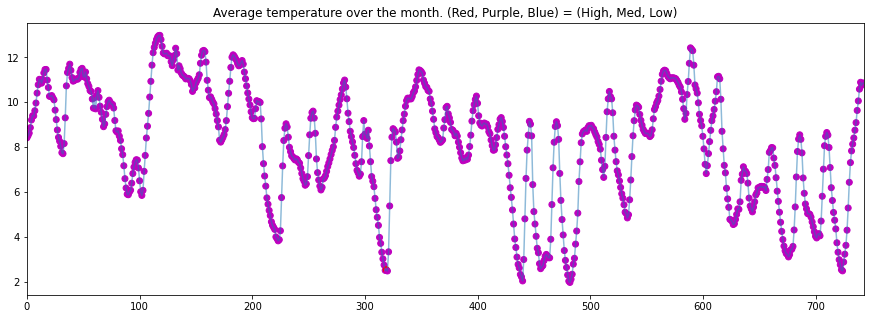

In [71]:
colormap1 = []
majority_class = np.zeros((len(temperature_df),G_gaussian.N))
for i in range(G_gaussian.N):
    for j in range(len(temperature_df)):
        idx = np.argmax([group1[i*len(temperature_df)+j],group2[i*len(temperature_df)+j],group3[i*len(temperature_df)+j]]).astype(int)
        colormap1.append(idx) 
        majority_class[j,i]=[0,1,2][idx]
        

colormap2 = []
for j in range(len(temperature_df)):
    colormap2.append(np.argmax([np.sum(majority_class[j]==0),np.sum(majority_class[j]==1),np.sum(majority_class[j]==2)]).astype(int))




x1 = np.arange(len(temperature_df)*G_gaussian.N)
x2 = np.arange(len(temperature_df))

colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, colormap2)
fig, ax = fig_ax()
ax.plot(x2, y, alpha=0.5)
ax.set_title('Average temperature over the month. (Red, Purple, Blue) = (High, Med, Low)')
ax.scatter(x2, y, c=color_array)